## Imports and common functions

In [61]:
import os
import json

# analysis
import pandas as pd
import numpy as np
import reverse_geocoder as rg

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
with open('config.json') as json_data:
    d = json.load(json_data)
    GOOGLE_MAPS_API_KEY = d['google-maps-key']

## Load in data
Check if CSV data exists, otherwise parse .dat files into csv

In [2]:
def load_dat_file(file_name, n_components):  
    """
    Loads in .dat files as lists. 
    
    Inputs: 
        file_name (string): name of file to load in
        n_components (int): number of components in row
        
    Outputs:
        (list): list of rows in data file
    """
    new_lines = []
    with open(file_name) as input_file:
        for line in input_file:
            new_line = [x.strip() for x in line.split('|')]
            
            if len(new_line) == n_components:
                new_lines.append(new_line)
    return new_lines

def read_data(directory, file_name, components=None):
    """
    Check to see if csv file exists, if not read in and parse dat file
    
    Inputs:
        directory (string): directory where data is stored
        file_name (string): file name WITHOUT extension
        components (int): number of components if reading from dat file
        
    Output:
        (pandas dataframe): dataframe with formatted 
    """
    if os.path.isfile(directory + file_name + '.csv'):
        print 'Reading csv file: ' + directory + file_name + '.csv'
        return pd.read_csv(directory + file_name + '.csv')
    else:
        if components is not None:
            print 'Parsing dat file: ' + directory + file_name + '.dat'
            # load in data 
            raw_data = load_dat_file(directory + file_name + '.dat', components)
            data_df = pd.DataFrame(raw_data[1:], columns=raw_data[0])
            
            # drop all rows with blank entires
            data_df.replace('', np.nan, inplace=True)
            data_df.dropna(inplace=True)
            
            # save as csv
            data_df.to_csv(directory + file_name + '.csv', index=False)
            
            # return parsed data
            return data_df
        else:
            return None

In [3]:
# read in each data frame
checkin_df = read_data('./raw_data/', 'checkins', components=6)
ratings_df = read_data('./raw_data/', 'ratings', components=3)
socialgraph_df = read_data('./raw_data/', 'socialgraph', components=2)
user_df = read_data('./raw_data/', 'users', components=3)
venues_df = read_data('./raw_data/', 'venues', components=3)

Reading csv file: ./raw_data/checkins.csv
Reading csv file: ./raw_data/ratings.csv
Reading csv file: ./raw_data/socialgraph.csv
Reading csv file: ./raw_data/users.csv
Reading csv file: ./raw_data/venues.csv


## Data Cleaning

### Select venues in United States only

In [4]:
# assign cities and countries
current_reverse_geocode = rg.search(zip(venues_df['latitude'], venues_df['longitude']))
cities = [x['name'] for x in current_reverse_geocode]
states = [x['admin1'] for x in current_reverse_geocode]
countries = [x['cc'] for x in current_reverse_geocode]

venues_df['city'] = cities
venues_df['state'] = states
venues_df['country'] = countries

Loading formatted geocoded file...


In [5]:
# select venues where country are in US
venues_df = venues_df[venues_df['country'] == 'US']

# select checkins and ratings that are only for venues in US 
checkin_df = checkin_df[checkin_df['venue_id'].isin(venues_df['id'])]
ratings_df = ratings_df[ratings_df['venue_id'].isin(venues_df['id'])]

# select users who made checkins or ratings
user_df = user_df[user_df['id'].isin(checkin_df['user_id'] + ratings_df['user_id'])]
socialgraph_df = socialgraph_df[socialgraph_df['first_user_id'].isin(user_df['id'])]

## Exploratory Analysis

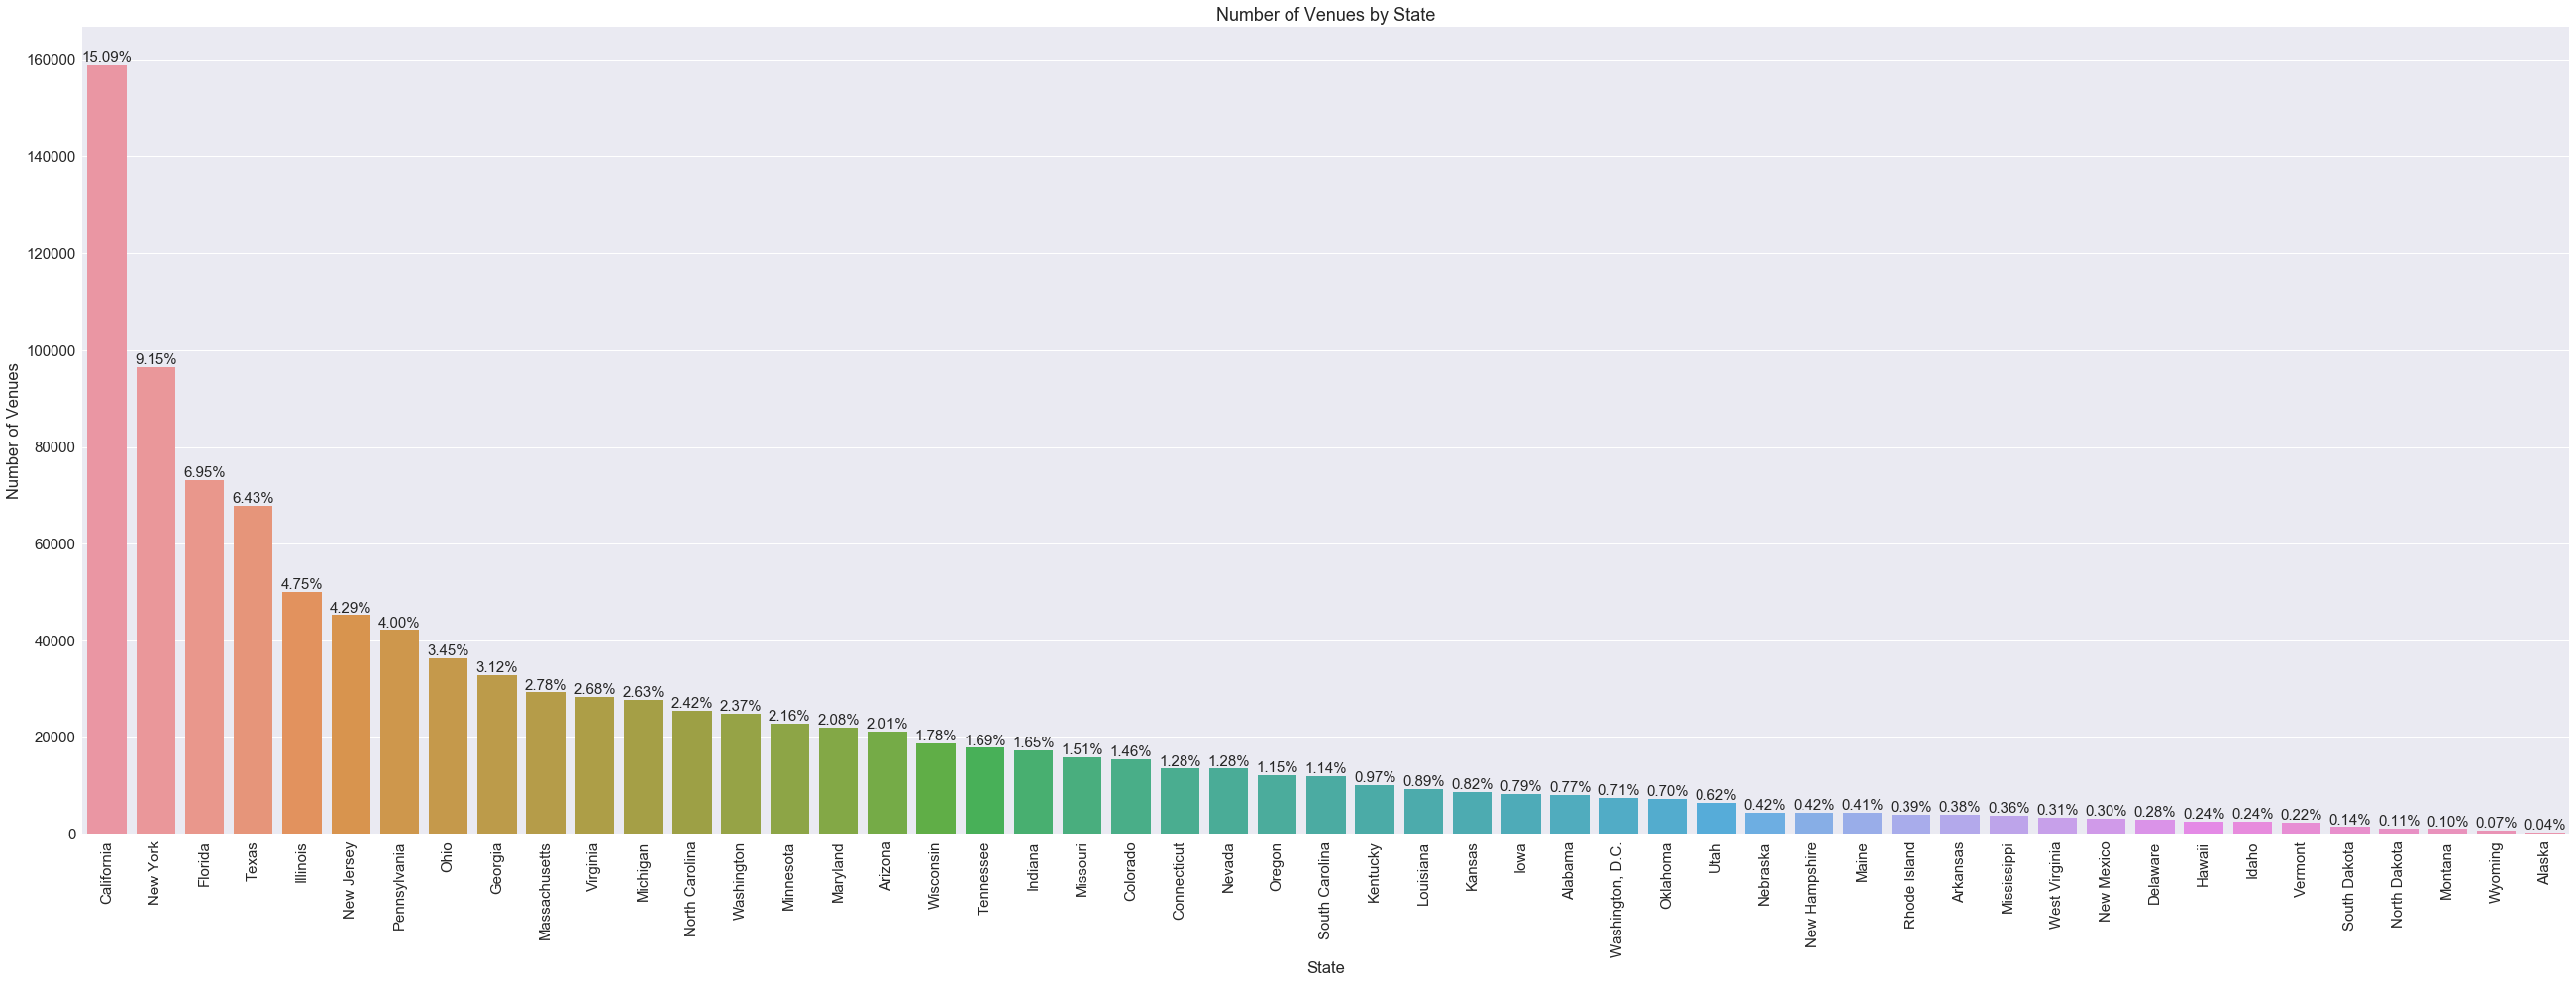

In [37]:
sns.despine();
sns.set(font_scale=1.5);

fig, ax = plt.subplots(figsize=(45, 15));
state_ordering = venues_df['state'].value_counts().index.tolist()
state_count = sns.countplot(venues_df['state'], order=state_ordering)
state_count.set_xlabel('State')
state_count.set_ylabel('Number of Venues')
state_count.set_title('Number of Venues by State')
plt.xticks(rotation=90)

total = len(venues_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height,
            '{:1.2f}%'.format(100 * height / total),
            ha='center',
            va='bottom',
            fontsize=15) 

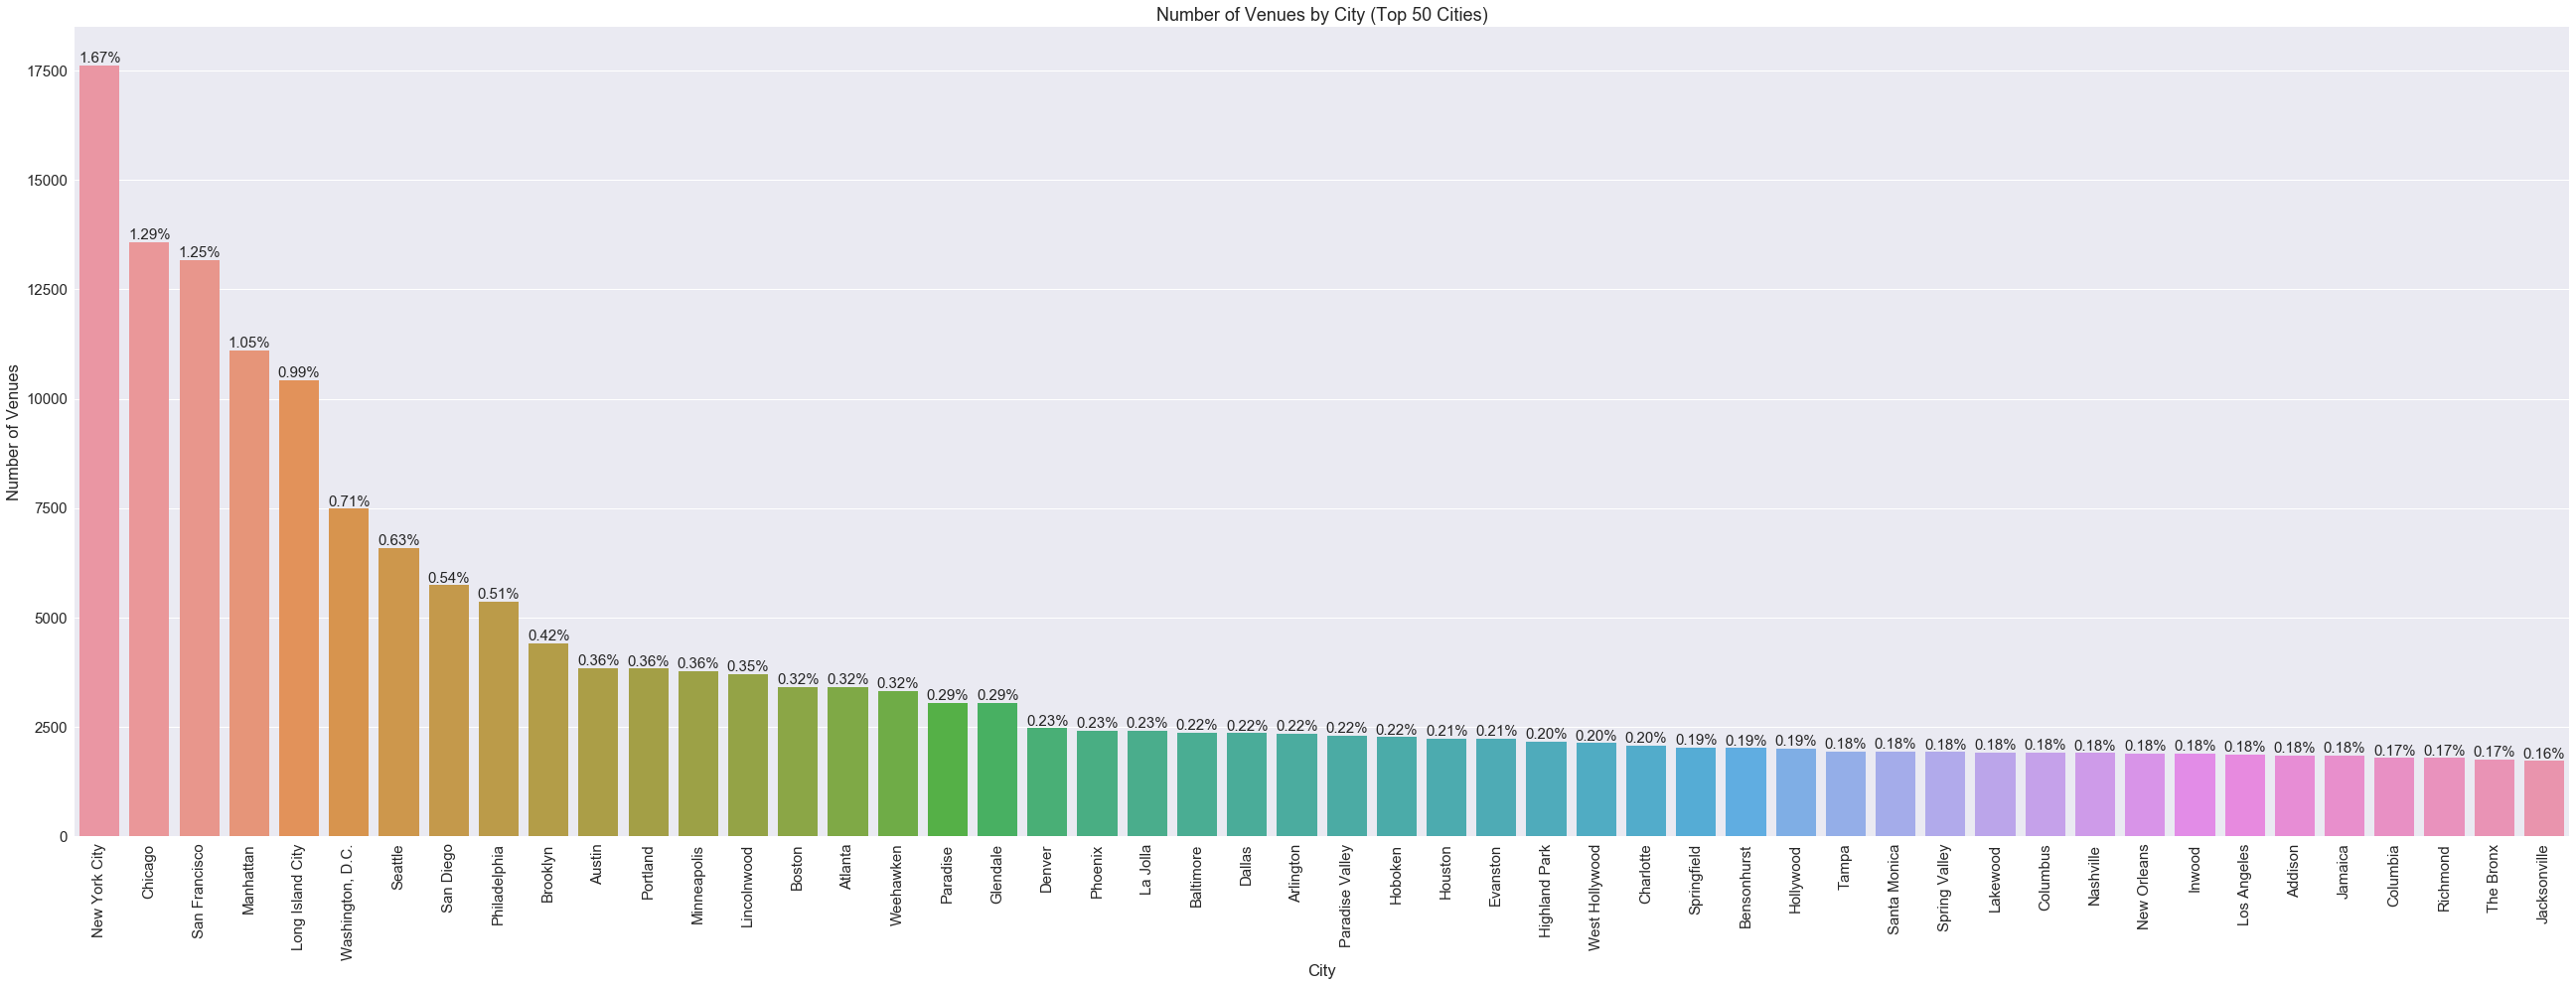

In [38]:
sns.despine();
sns.set(font_scale=1.5);

fig, ax = plt.subplots(figsize=(45, 15));
city_ordering = venues_df['city'].value_counts().index.tolist()[0:50]
city_count = sns.countplot(venues_df[venues_df['city'].isin(city_ordering)]['city'], order=city_ordering)
city_count.set_xlabel('City')
city_count.set_ylabel('Number of Venues')
city_count.set_title('Number of Venues by City (Top 50 Cities)')
plt.xticks(rotation=90)

total = len(venues_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height,
            '{:1.2f}%'.format(100 * height / total),
            ha='center',
            va='bottom',
            fontsize=15) 